Look out for Dummy Variable Trap (might not be relevant for cuisine types since they can overlap)

In [3]:
from bs4 import BeautifulSoup
import re
import json
import requests
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import nltk
from collections import defaultdict
from copy import deepcopy
#nltk.download('wordnet')
from nltk.corpus import wordnet as wn
% matplotlib inline

In [4]:
# Scraping Functions
def gather_allmenus_links(restaurant_type):

    major_url = f'https://www.allmenus.com/ca/san-francisco/-/{restaurant_type.lower()}/'
    major_r = requests.get(major_url).text
    major_soup = BeautifulSoup(major_r, 'html5lib')
    major_parent = major_soup.find_all('section', class_ = 'restaurant-list-container s-col-md-8')[0]
    r_list = major_parent.find_all('li', class_  = 'restaurant-list-item clearfix')
    
    url_list = []
    for link in r_list:
        r_url = link.find('a')
        url_list.append(f'https://www.allmenus.com{r_url.get("href")}')
    
    return set(url_list)


def scrape_json(url):
    
    soup = BeautifulSoup(requests.get(url).text, 'html5lib')
    parent = soup.find_all('head')[0]
    children = parent.find_all("script")
    menu_child = children[1]
    json_html = re.sub(r'\r|\n', '', menu_child.text)
    return json.loads(json_html)
    

In [5]:
# Interpreting Data Functions
def get_dish_features(entry, name_list, desc_list, price_list):
    
    name_list.append(entry['name'])
    desc_list.append(entry['description'])
    # This is to catch entries missing price
    try:
        offers_list = entry['offers']
        first_offer = offers_list[0]
        price_list.append(first_offer['Price'])
    except:
        price_list.append(None)

def create_menudf(json, Res_Name):
    
    total_df = pd.DataFrame(columns = ['Menu Section', 'Menu Section Desc', 'Dish Name', 'Dish Desc', 'Dish Price'])
    
    try:
        menu_info = json['hasMenu'][0]
    except IndexError:
        print(f'No Menu for {Res_Name}')
        return None

    for MenuSections in menu_info['hasMenuSection']:

        # Holding name and description for each menu section
        MenuSectionName = MenuSections['name']
        MenuSectionDesc = MenuSections['description']

        # Lists that get_dish_features will be appending to
        ItemNames = []
        ItemDescs = []
        ItemPrices = []

        for Dish in MenuSections['hasMenuItem']:
            get_dish_features(Dish, ItemNames, ItemDescs, ItemPrices)

        section_df = pd.DataFrame({'Menu Section': MenuSectionName,
                                   'Menu Section Desc': MenuSectionDesc,
                                   'Dish Name': ItemNames,
                                   'Dish Desc': ItemDescs,
                                   'Dish Price': ItemPrices})

        total_df = total_df.append(section_df)

    total_df = total_df.reset_index(drop = True)
    return total_df

In [6]:
class Restaurant:
    
    def __init__(self, json):
        self.Name = json['name']
        self.Geo = json['geo']
        self.Types = json['servesCuisine']
        self.Menudf = create_menudf(json, json['name'])
        
    def get_coordinates(self):
        coords = (self.Geo['latitude'], self.Geo['longitude'])
        return coords

In [7]:
def create_rest_pkl(types_list, x, filename):
    
    restaurant_list = []
    urls = []
    
    for rest_type in types_list:
        time.sleep(np.random.poisson(x))
        urls += gather_allmenus_links(rest_type)
    urls = set(urls)
    
    for i, link in enumerate(urls):
        if i % 10 == 0:
            print(i)
        time.sleep(np.random.poisson(x))
        try:
            restaurant_list.append(Restaurant(scrape_json(link)))
        except json.JSONDecodeError:
            print(f"Wasn't able to retrive JSON of: {link}")
        except KeyError:
            print(f"Had trouble processing dict of: {link}")
            
    with open(filename, 'wb') as picklefile: # 'wb' = write binary
        pickle.dump(restaurant_list, picklefile)

In [8]:
multi_list1 = ['american', 'mediterranean', 'mexican']
multi_list2 = ['cajun-creole', 'pakistani', 'african']

In [628]:
create_rest_pkl(multi_list2, 3, 'multi_list2.pkl' )

0
10
20
30
40
Had trouble processing dict of: https://www.allmenus.com/ca/san-francisco/276476-al-hamra/menu/


In [9]:
with open('multi_list.pkl', 'rb') as picklefile:
    rest_list1 = pickle.load(picklefile)

In [10]:
with open('multi_list2.pkl', 'rb') as picklefile:
    rest_list2 = pickle.load(picklefile)

In [817]:
len(rest_list1)

834

In [11]:
def grab_nouns(txt):
    split_txt = re.split('[ &.]', txt)
    noun_list = []
    for i in split_txt:
        syn_list = wn.synsets(i)
        if len(syn_list) < 1 or len(i) < 3:
            pass
        elif syn_list[0].pos() == 'n':
            first_syn = syn_list[0]
            new_noun = first_syn.name().replace('_', '.').replace('-', '.')
            noun_list.append(new_noun.split('.')[0])
                
    return list(set(noun_list))      

In [12]:
def get_ingredients(alphabet_list, t, filename):
    
    all_ingredients = []
    
    for letter in alphabet_list:
        
        time.sleep(np.random.poisson(t))
        bbc_site = f'https://www.bbc.com/food/ingredients/by/letter/{letter}'
        ingr_soup = BeautifulSoup(requests.get(bbc_site).text, 'html5lib')
        ingredients = []
        try:
            parent = ingr_soup.find_all('ol', class_ = 'resources-by-letter')[0]
            for item in parent.find_all('li', class_ = 'resource food'):
                link = item.find('a')
                ingr = link.text.lower()
                ingr = re.search(r'\S+', ingr).group()
                ingredients.append(ingr)

            all_ingredients += ingredients
        except IndexError:
            print(f'No ingredients starting with {letter}')
    
    all_ingredients = set(all_ingredients)
    
    with open(filename, 'wb') as picklefile: # 'wb' = write binary
        pickle.dump(all_ingredients, picklefile)
        
    return set(all_ingredients)

In [ ]:
get_ingredients(list(string.ascii_lowercase), 3, 'ingredients_list.pkl')

Get base words of ingredient list

In [13]:
with open('ingredients_list.pkl', 'rb') as picklefile: # 'wb' = write binary
    all_ingredients = pickle.load(picklefile)
all_ingredients = [wn.synsets(i)[0].name().replace('_','.').split('.')[0] for i in all_ingredients if len(wn.synsets(i)) > 0]
all_ingredients = set(all_ingredients)

Screening words for menu sections

In [14]:
appetizer_words = ['appetizer', 'starter', 'oyster']
entree_words = ['supper', 'dinner', 'special', 'main', 'entree', 'brunch',
                'meal', 'salad', 'burger', 'breakfast', 'sandwich', 'pizza',
               'curry', 'pasta', 'omelet',]
dessert_words = ['dessert']
section_words = set(appetizer_words + entree_words + dessert_words)
# Unallowed words are to remove keywords that signaled large format dishes
unallowed_words = set(['platter', 'home', 'catering', 'tray'])

In [15]:
rest_list = rest_list1 + rest_list2
all_types = []
for i_rest in [i.Types for i in rest_list]:
    all_types += [i_type.replace(' &amp; ', '-').split( )[0].lower() for i_type in i_rest]

all_types = set(all_types)
#all_types = multi_list1 + multi_list2
#all_types = all_types[1:]

In [16]:
total_df = pd.DataFrame()
for a in rest_list:
    if type(a.Menudf) != pd.DataFrame:
        pass
    else:
        df = a.Menudf
        df['Restaurant Name'] = a.Name
        df['Latitude'] = a.get_coordinates()[0]
        df['Longitude'] = a.get_coordinates()[1]
        df['Restaurant Types'] = [a.Types] * len(df)
        total_df = total_df.append(df)
total_df = total_df[['Dish Price', 'Restaurant Name', 'Restaurant Types', 'Longitude', 'Latitude',
                     'Menu Section', 'Menu Section Desc', 'Dish Name', 'Dish Desc']]
total_df.fillna(value = np.nan, inplace = True)
total_df.dropna(how = 'any', inplace = True)
total_df = total_df[total_df['Dish Price'] != '']
total_df[['Longitude', 'Latitude', 'Dish Price']] = total_df[['Longitude', 'Latitude', 'Dish Price']].applymap(float)
total_df['Total Dish Text'] = total_df['Dish Name'] + ' ' +  total_df['Dish Desc']
total_df['Total Dish Text'] = total_df['Total Dish Text'].apply(lambda x: x.lower())
total_df['Dish Nouns'] = total_df['Total Dish Text'].apply(grab_nouns)
total_df['Section Nouns'] = total_df['Menu Section'].apply(grab_nouns).apply(tuple)
# Make sure that dishes are entrees, desserts, or appetizers
total_df['Allowable Section'] = total_df['Section Nouns'].apply(lambda x: True 
                                                                if (len(section_words.intersection(set(x))) > 0) &
                                                                    (len(unallowed_words.intersection(set(x))) < 1)
                                                                else False)
total_df['Ingredients'] = total_df['Dish Nouns'].apply(lambda x: all_ingredients.intersection(set(x)))
total_df['N_Ingredients'] = total_df['Ingredients'].apply(len)

total_df = total_df[total_df['Allowable Section'] == True].reset_index(drop = True)
total_df = total_df.drop(labels = ['Menu Section Desc', 'Dish Name', 'Menu Section', 
                                   'Dish Desc', 'Total Dish Text',
                                   'Allowable Section', 'Dish Nouns'], axis = 1)
total_df = total_df[total_df['N_Ingredients'] != 0]
total_df['Restaurant Types'] = (total_df['Restaurant Types']
                                .apply(lambda x: [i.replace(' &amp; ', '-').lower() for i in x])
                                .apply(tuple))
for i_type in all_types:
    total_df[f'{i_type}_Type'] = total_df['Restaurant Types'].apply(lambda x: 1 if f'{i_type}' in x else 0)
total_df['N_Types'] = total_df['Restaurant Types'].apply(len)

total_df = total_df.drop(labels = ['Restaurant Name', 'Restaurant Types'], axis = 1)
#total_df = total_df.drop(labels = ['Restaurant Name'], axis = 1)
# Delete any Dish less than $1
total_df = total_df[total_df['Dish Price'] > 1]

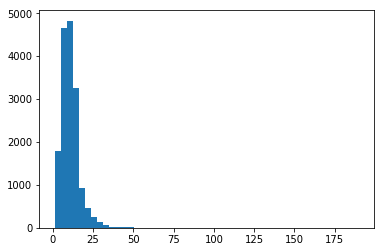

In [213]:
plt.hist(price_df['Dish Price'], bins = 50);

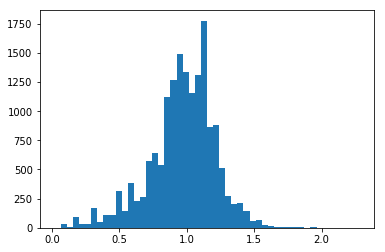

In [223]:
plt.hist(price_df['Dish Price'].apply(np.log10), bins = 50);

In [17]:
price_df = total_df[['Dish Price', 'Ingredients', 'N_Ingredients']]
price_df['N/P'] = np.round(total_df['Dish Price'] / total_df['N_Ingredients'], 2)
zip_list = list(zip(price_df['Ingredients'], price_df['N/P']))
tup_list = [[(i, j[1]) for i in j[0]] for j in zip_list]
price_df['Tuples'] = tup_list

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [18]:
price_list = np.sum(price_df['Tuples'].values)

In [19]:
N_dict = defaultdict(int)
price_dict = defaultdict(float)
for entry in price_list:
    price_dict[entry[0]] += entry[1]
    N_dict[entry[0]] += 1

In [20]:
def get_mock_price(x, pdict, Ndict):
    price_list = [pdict[i] / Ndict[i] for i in x]
    return np.sum(price_list)

In [21]:
price_df['Mock_Price'] = price_df['Ingredients'].apply(lambda x: get_mock_price(x, price_dict, N_dict))
total_df['Mock_Price'] = price_df['Ingredients'].apply(lambda x: get_mock_price(x, price_dict, N_dict))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [22]:
lowcost_df = total_df[total_df['Dish Price'] < 10][['Dish Price', 'Ingredients']]
print(lowcost_df.shape)
midcost_df = total_df[(total_df['Dish Price'] >= 10) & (total_df['Dish Price'] < 30)][['Dish Price', 'Ingredients']]
print(midcost_df.shape)
highcost_df = total_df[(total_df['Dish Price'] >= 30)][['Dish Price', 'Ingredients']]
print(highcost_df.shape)

(8358, 2)
(7934, 2)
(185, 2)


In [23]:
lowcost_list = pd.Series(np.sum(lowcost_df['Ingredients'].apply(list).values))
midcost_list = pd.Series(np.sum(midcost_df['Ingredients'].apply(list).values))
highcost_list = pd.Series(np.sum(highcost_df['Ingredients'].apply(list).values))

In [50]:
lc = set(lowcost_list.value_counts()[:50].index.values)
mc = set(midcost_list.value_counts()[:50].index.values)
hc = set(highcost_list.value_counts()[:50].index.values)

hc_only = hc - lc - mc
hc_mc = hc - mc
hc_lc = hc - lc
mc_only = mc - lc - hc
mc_lc = hc - lc
lc_only = lc - mc - hc

In [49]:
mc - lc

{'basil',
 'brown',
 'coriander',
 'corn',
 'crab',
 'lamb',
 'land',
 'mozzarella',
 'rocket',
 'salmon',
 'steak',
 'white'}

In [26]:
import statsmodels.api as sm
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn import preprocessing
from sklearn.model_selection import learning_curve
from sklearn.cross_validation import KFold
import seaborn as sns

min_max_scaler = preprocessing.MinMaxScaler()

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [66]:
model_df = deepcopy(total_df)
model_df['LC_Ingredients'] = model_df['Ingredients'].apply(lambda x: len(lc_only.intersection(x)))
model_df['MC_Ingredients'] = model_df['Ingredients'].apply(lambda x: len(mc_only.intersection(x)))
model_df['HC_Ingredients'] = model_df['Ingredients'].apply(lambda x: len(hc_only.intersection(x)))
model_df['HCMC_Ingredients'] = model_df['Ingredients'].apply(lambda x: len(hc_mc.intersection(x)))
model_df['HCLC_Ingredients'] = model_df['Ingredients'].apply(lambda x: len(hc_lc.intersection(x)))
model_df['MCLC_Ingredients'] = model_df['Ingredients'].apply(lambda x: len(mc_lc.intersection(x)))
model_df['Appetizer_Dish'] = model_df['Section Nouns'].apply(lambda x: 1 if 
                                                             len(set(appetizer_words).intersection(x)) > 0
                                                            else 0)
model_df['Entree_Dish'] = model_df['Section Nouns'].apply(lambda x: 1 if
                                                          len(set(entree_words).intersection(x)) > 0
                                                         else 0)
# remove this because of dummy variable trap
#model_df['Dessert_Dish'] = model_df['Section Nouns'].apply(lambda x: 1 if len(set(dessert_words).intersection(x)) > 0
#                                                          else 0)
model_df = model_df.drop(labels = ['Ingredients', 'Section Nouns'], axis = 1)

#model_df['Longitude'] = min_max_scaler.fit_transform(model_df['Longitude'].values.reshape(-1,1))
#model_df['Latitude'] = min_max_scaler.fit_transform(model_df['Latitude'].values.reshape(-1,1))
print(model_df.shape)
model_df.head()

(16477, 90)


,Dish Price,Longitude,Latitude,N_Ingredients,soul_Type,peruvian_Type,fish-chips_Type,eastern_Type,wild_Type,afghan_Type,...,N_Types,Mock_Price,LC_Ingredients,MC_Ingredients,HC_Ingredients,HCMC_Ingredients,HCLC_Ingredients,MCLC_Ingredients,Appetizer_Dish,Entree_Dish
0,6.75,-122.415617,37.768297,3,0,0,0,0,0,0,...,1,7.561804,0,0,0,0,0,0,0,1
1,6.50,-122.415617,37.768297,1,0,0,0,0,0,0,...,1,2.436524,0,0,0,0,0,0,0,1
2,6.75,-122.415617,37.768297,2,0,0,0,0,0,0,...,1,4.993896,0,0,0,0,0,0,0,1
3,6.75,-122.415617,37.768297,2,0,0,0,0,0,0,...,1,4.836224,0,0,0,0,0,0,0,1
4,6.75,-122.415617,37.768297,4,0,0,0,0,0,0,...,1,8.712224,0,0,0,0,0,0,0,1


In [29]:
start_cols = [x + '_Type' for x in multi_list1 + multi_list2[1:]]
start_cols

['american_Type',
 'mediterranean_Type',
 'mexican_Type',
 'pakistani_Type',
 'african_Type']

In [69]:
base_cols = ['Mock_Price', 'LC_Ingredients', 'HC_Ingredients', 'HCMC_Ingredients', 
             'HCLC_Ingredients', 'MCLC_Ingredients', 'Longitude', 'Latitude',
             'MC_Ingredients', 'N_Types', 'N_Ingredients']

In [73]:
import itertools
creation_list = ['Mock_Price', 'N_Types', 'N_Ingredients', 'Longitude', 'Latitude']
#creation_list = base_cols
possible_list = [i for i in itertools.product(creation_list, creation_list)]
cutdown_list = set([tuple(sorted(i)) for i in possible_list])

In [82]:
y_vals = model_df.iloc[:, 0]
y_vals = y_vals.apply(np.log)
X_vals = model_df.iloc[:, 1:]
#X_vals = model_df[base_cols]
X_vals['Log_MockPrice'] = model_df['Mock_Price'].apply(np.log10)
for i in cutdown_list:
    X_vals[f'{i[0]} x {i[1]}'] = model_df[i[0]] * model_df[i[1]]
#for i in creation_list:
    #X_vals[f'Sqrt_{i}'] = model_df[i].apply(np.sqrt)
    #X_vals[f'{i}^3'] = model_df[i].apply(lambda x: np.power(x,3))

X_train, X_test, y_train, y_test = train_test_split(X_vals, y_vals, test_size=0.3, random_state = 42)

In [83]:
linmodel = sm.OLS(y_train, sm.add_constant(X_train)).fit()
linmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Dish Price   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     70.49
Date:                Fri, 13 Jul 2018   Prob (F-statistic):               0.00
Time:                        01:51:37   Log-Likelihood:                -7111.5
No. Observations:               11533   AIC:                         1.440e+04
Df Residuals:                   11443   BIC:                         1.506e+04
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                         -4.698e+05   1.14e+05     -4.138      0.000   -6.92e+05   -2.47e+05
Longitude                     -7103.5784   1565.539     -4.537      0.000   -1.02e+04   -4034.854
Latitude                       1847.0925   1585.246      1.165      0.244   -1260.261    4954.445
N_Ingredients                   -55.3894     45.952     -1.205      0.228    -145.464      34.685
soul_Type                      3.094e-08   1.23e-07      0.253      0.801   -2.09e-07    2.71e-07
peruvian_Type                     0.0587      0.041      1.415      0.157      -0.023       0.140
fish-chips_Type                  -0.0964      0.135     -0.714      0.475      -0.361       0.168
eastern_Type                   7.114e-09   2.93e-08      0.243      0.808   -5.04e-08    6.46e-08
wild_Type                      3.498e-09   1.45e-08      0.242      0.809   -2.48e-08    3.18e-08
afghan_Type                      -0.1658      0.145     -1.140      0.254      -0.451       0.119
other_Type                       -0.4685      0.160     -2.928      0.003      -0.782      -0.155
spanish_Type                     -0.3270      0.452     -0.723      0.470      -1.213       0.559
eclectic-international_Type      -0.1407      0.037     -3.837      0.000      -0.213      -0.069
portuguese_Type                   0.3979      0.083      4.774      0.000       0.235       0.561
pakistani_Type                   -0.3084      0.184     -1.674      0.094      -0.670       0.053
gastropub_Type                   -0.0110      0.037     -0.293      0.769      -0.084       0.062
burgers_Type                     -0.1236      0.026     -4.726      0.000      -0.175      -0.072
greek_Type                        0.2243      0.047      4.816      0.000       0.133       0.316
latin_Type                    -1.484e-10    5.8e-10     -0.256      0.798   -1.29e-09    9.89e-10
vietnamese_Type                  -0.2204      0.074     -2.984      0.003      -0.365      -0.076
ethiopian_Type                    0.4025      0.087      4.635      0.000       0.232       0.573
cocktails_Type                    0.0668      0.022      3.003      0.003       0.023       0.110
bakery-pastries_Type              0.0886      0.082      1.077      0.281      -0.073       0.250
mexican_Type                     -0.2002      0.016    -12.134      0.000      -0.232      -0.168
turkish_Type                      0.1063      0.078      1.354      0.176      -0.048       0.260
tapas_Type                       -0.0977      0.036     -2.694      0.007      -0.169      -0.027
pizza_Type                        0.0327      0.033      0.980      0.327      -0.033       0.098
french_Type                       0.1229      0.049      2.519      0.012       0.027       0.219
german_Type                      -0.0888     

In [60]:
# 10-fold cross-validation
reg = LinearRegression()
scores = cross_val_score(reg, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print(-scores)

[0.19771005 0.21304198 0.17854721 0.18893886 0.2199638  0.21446343
 0.21486672 0.19963576 0.22017335 0.19214118]


In [223]:
less_features = [0.23693381, 0.23716061, 0.23743435, 0.20460231, 0.22196939, 0.23380482,
 0.21535045, 0.23738111, 0.23919472, 0.24133802]

all_features = [0.20286102, 0.21893007, 0.18712391, 0.19713739, 0.22794762, 0.22311416,
 0.21922814, 0.20634287, 0.22840307, 0.19588376]

print(f'Less features mean: {np.mean(less_features)}\nMore features mean: {np.mean(all_features)}')

Less features mean: 0.23051695900000002
More features mean: 0.21069720099999997


In [61]:
train_sizes, train_scores, test_scores = learning_curve(reg, X_train, y_train, cv = 20)
ave_train_scores = train_scores.mean(axis=1)
ave_test_scores = test_scores.mean(axis=1)
learn_df = pd.DataFrame({
    'train_size': train_sizes,
    'train_score': ave_train_scores,
    'test_score': ave_test_scores
})
learn_df


,train_size,train_score,test_score
0,1095,0.410349,0.293814
1,3560,0.390532,0.333628
2,6025,0.371212,0.338327
3,8490,0.363838,0.341885
4,10956,0.354314,0.343614


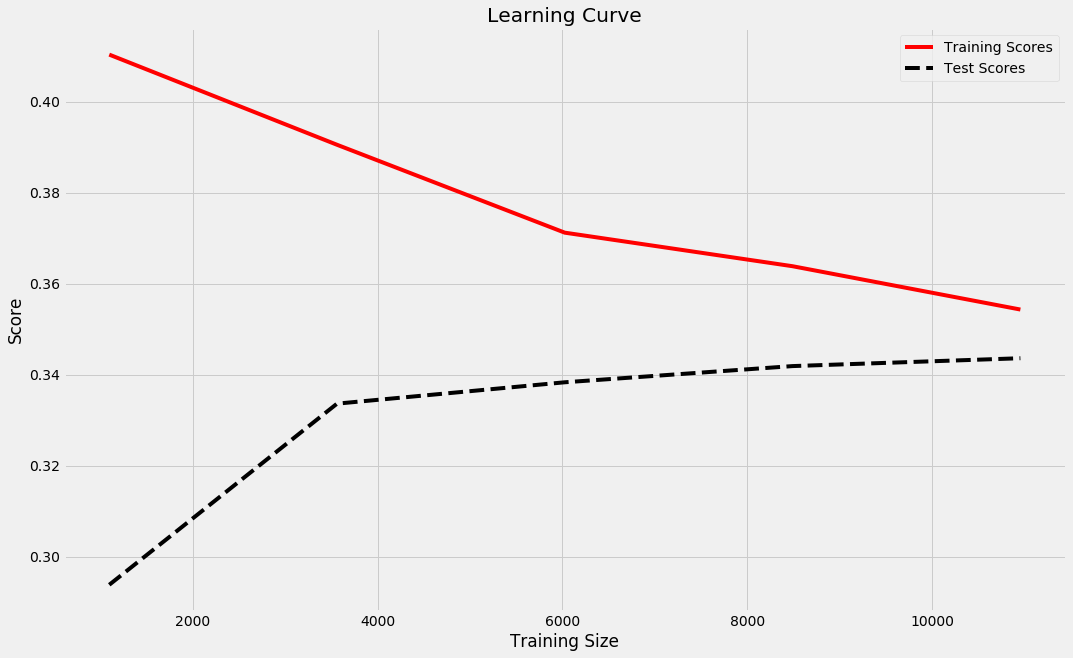

In [113]:
plt.plot(learn_df['train_size'].values, learn_df['train_score'].values, 'r-',
        learn_df['train_size'].values, learn_df['test_score'].values, 'k--')
plt.legend(['Training Scores', 'Test Scores'])
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve');
plt.savefig('Learning_Curve.png', format = 'png')

In [238]:
from sklearn import feature_selection as f_select
est=LinearRegression()
X = deepcopy(X_train.reset_index(drop = True))
y = deepcopy(y_train.reset_index(drop = True))


kf=KFold(n=len(X),n_folds=5,shuffle=True)

all_scores=[]

# Instead of using cross_val_score, let's use sklearn.cross_validation.KFold; this will allow
# us to 'manipulate' our training set, 

# get indices of corresponding train & test
for train,test in kf:
    x_train=X.iloc[train]
    y_train=y.iloc[train]
    x_test=X.iloc[test]
    y_test=y.iloc[test]
    pvals=[]
    sig_cols=[]
    
    for feature in x_train.columns:
        pval=f_select.f_regression(x_train[[feature]],y_train)
        if pval[1][0]<.02: 
            sig_cols.append(feature)
            pvals.append(pval[1][0])
            
    est.fit(x_train[sig_cols],y_train)
    r_2=est.score(x_test[sig_cols],y_test)
    all_scores.append(r_2)

/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [239]:
print(sig_cols)
np.mean(all_scores)

['Longitude', 'Latitude', 'N_Ingredients', 'breakfast_Type', 'indian_Type', 'californian_Type', 'cuban_Type', 'kosher_Type', 'gastropub_Type', 'local/organic_Type', 'american_Type', 'mexican_Type', 'vegetarian_Type', 'salads_Type', 'portuguese_Type', 'bakery-pastries_Type', 'alcohol_Type', 'chinese_Type', 'cocktails_Type', 'vietnamese_Type', 'burgers_Type', 'crepes_Type', 'steak_Type', 'bistro_Type', 'smoothies-juices_Type', 'seafood_Type', 'french_Type', 'italian_Type', 'chicken_Type', 'sushi_Type', 'southwestern_Type', 'coffee-tea_Type', 'mediterranean_Type', 'peruvian_Type', 'eclectic-international_Type', 'sandwiches_Type', 'cajun-creole_Type', 'healthy_Type', 'pakistani_Type', 'japanese_Type', 'ethiopian_Type', 'greek_Type', 'Mock_Price', 'LC_Ingredients', 'MC_Ingredients', 'HC_Ingredients', 'Log_MockPrice', 'Mock_Price x N_Ingredients', 'Mock_Price x Mock_Price', 'Longitude x Mock_Price', 'Latitude x Mock_Price', 'Longitude x N_Ingredients', 'Latitude x N_Ingredients', 'Longitude 

0.3114735079455319

In [ ]:
sns.pairplot(pd.concat([y_vals, X_vals], axis = 1));

In [ ]:
new_cols = list(linmodel.params.loc[(linmodel.pvalues > 0.02) == True].index) + ['N_Types']
new_cols = new_cols[1:]
new_cols

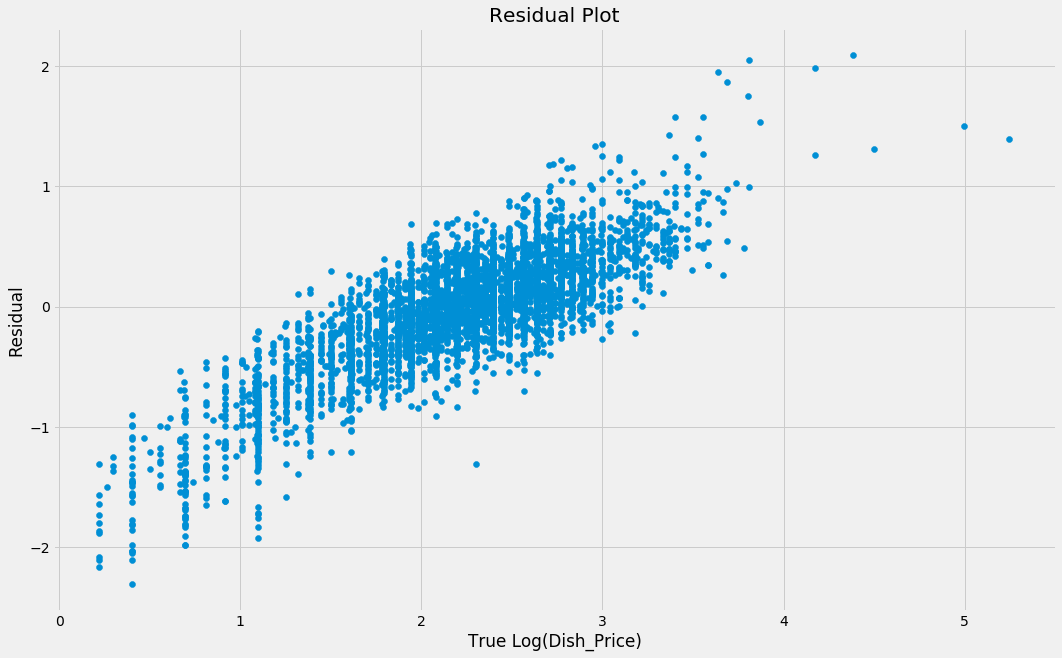

In [110]:
plt.rc('figure', figsize=(16.0, 10.0))
plt.style.use('fivethirtyeight')
y_predict = linmodel.predict(sm.add_constant(X_test))
plt.scatter(y_test, (y_test - y_predict))
plt.xlabel('True Log(Dish_Price)')
plt.ylabel('Residual');
plt.title('Residual Plot');
plt.savefig('Residual_Plot.png', format = 'png')

In [101]:
y_test.notnull().value_counts()
X_test.notnull().describe()

,Longitude,Latitude,N_Ingredients,soul_Type,peruvian_Type,fish-chips_Type,eastern_Type,wild_Type,afghan_Type,other_Type,...,Latitude x Latitude,N_Types x N_Types,Longitude x Longitude,Mock_Price x N_Ingredients,Longitude x Mock_Price,Latitude x N_Types,N_Ingredients x N_Types,Longitude x N_Types,Latitude x Mock_Price,Latitude x Longitude
count,4944,4944,4944,4944,4944,4944,4944,4944,4944,4944,...,4944,4944,4944,4944,4944,4944,4944,4944,4944,4944
unique,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
top,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
freq,4944,4944,4944,4944,4944,4944,4944,4944,4944,4944,...,4944,4944,4944,4944,4944,4944,4944,4944,4944,4944


In [114]:
import diagnostic_plots as dp_plot

/anaconda3/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:323: RuntimeWarning: invalid value encountered in sqrt
  return  self.results.resid / sigma / np.sqrt(1 - hii)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/User/github/project_luther/diagnostic_plots.py:131: RuntimeWarning: invalid value encountered in sqrt
  graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x),
/Users/User/github/project_luther/diagnostic_plots.py:134: RuntimeWarning: invalid value encountered in sqrt
  graph(lambda x: np.sqrt((1 * 

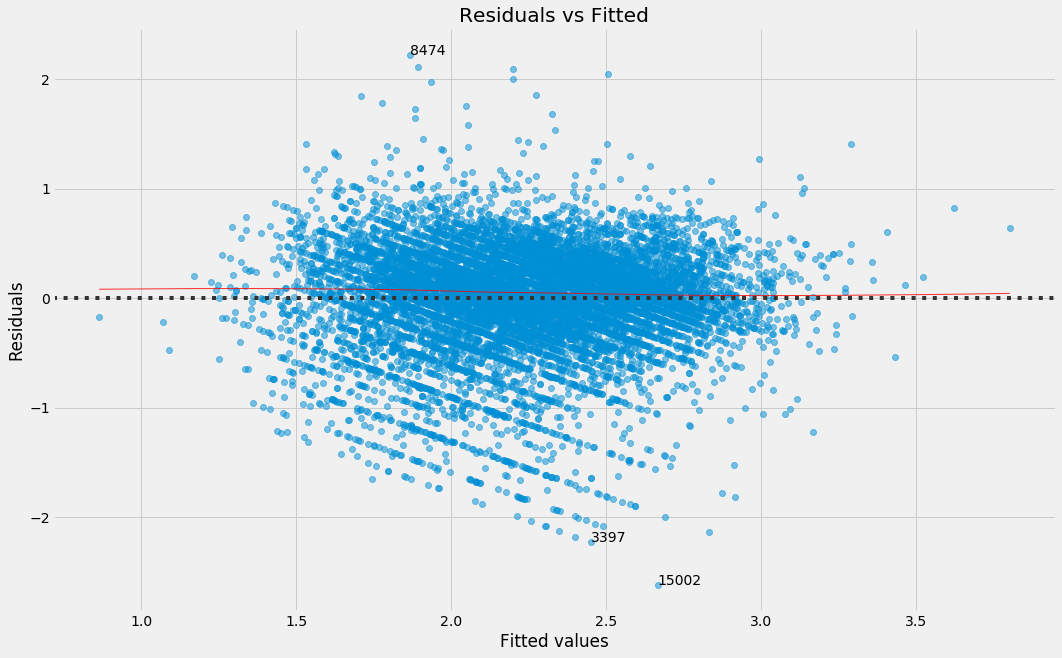

ValueError: cannot convert float NaN to integer

<Figure size 1152x720 with 1 Axes>

ValueError: cannot convert float NaN to integer

<Figure size 1152x720 with 1 Axes>

ValueError: cannot convert float NaN to integer

<Figure size 1152x720 with 1 Axes>

In [115]:
dp_plot.diagnostic_plots(sm.add_constant(X_train), y_train)

## Possible Goal: Topic Modeling

In [29]:
wn.synsets('boodle')[0].definition()

'informal terms for money'